# Trade Sentiment VS Trader Performance Analysis

## Objective
Analyze how Bitcoin market sentiment (Fear/Greed) relates to trader behavior and performance on Hyperliquid.Analyze how Bitcoin market sentiment (Fear/Greed) relates to trader behavior and performance on Hyperliquid.

## Step 1 — Data Loading & Initial Inspection
In this step, we:
- Load both datasets
- Inspect shape (rows/columns)
- Check missing values
- Check duplicates

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width',1000)

In [229]:
sentiment = pd.read_csv('fear_greed_index.csv')
print("===== BITCOIN SENTIMENT DATA =====")
print("Shape:", sentiment.shape)
print("\nColumns:")
print(sentiment.columns)
print("\nMissing Values:")
print(sentiment.isnull().sum())
print("\nDuplicate Rows:", sentiment.duplicated().sum())

===== BITCOIN SENTIMENT DATA =====
Shape: (2644, 4)

Columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Missing Values:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate Rows: 0


In [230]:

trade = pd.read_csv("historical_data.csv")

print("\n\n===== TRADER DATA =====")
print("Shape:", trade.shape)
print("\nColumns:")
print(trade.columns)
print("\nMissing Values:")
print(trade.isnull().sum())
print("\nDuplicate Rows:", trade.duplicated().sum())



===== TRADER DATA =====
Shape: (211224, 16)

Columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp'], dtype='object')

Missing Values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Duplicate Rows: 0


## Step 2 — Data Cleaning & Date Alignment
In this step, we:
- Convert date columns to proper datetime format
- Clean sentiment classifications
- Remove duplicate rows
- Handle missing values
- Convert trader timestamps to daily level
- Align both datasets on date for daily analysis

In [231]:
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [232]:
sentiment['classification'] = sentiment['classification'].str.strip().str.capitalize()

In [233]:
sentiment = sentiment[['date', 'value', 'classification']]

In [234]:

print("Sentiment date range:")
print("From:", sentiment['date'].min())
print("To:", sentiment['date'].max())

Sentiment date range:
From: 2018-02-01 00:00:00
To: 2025-05-02 00:00:00


In [235]:
trade['Timestamp'] = pd.to_datetime(trade['Timestamp'])

In [236]:
trade['date'] = trade['Timestamp'].dt.date
trade['date'] = pd.to_datetime(trade['date'])

print("\nTrader date range:")
print("From:", trade['date'].min())
print("To:", trade['date'].max())


Trader date range:
From: 1970-01-01 00:00:00
To: 1970-01-01 00:00:00


In [237]:
common_dates = set(sentiment['date']).intersection(set(trade['date']))

sentiment = sentiment[sentiment['date'].isin(common_dates)]
trade = trade[trade['date'].isin(common_dates)]

print("\nAfter Alignment:")
print("Sentiment shape:", sentiment.shape)
print("Trader shape:", trade.shape)


After Alignment:
Sentiment shape: (0, 3)
Trader shape: (0, 17)


## Step 3 — Create Daily Performance Metrics & Merge Sentiment

In this step:

1. Aggregate trader-level transactions into daily metrics
2. Compute:
   - Total PnL
   - Total Fees
   - Net PnL
   - Number of trades
   - Win rate
   - Long vs Short trade counts
3. Standardize Date Format
Ensure both datasets use the same normalized daily datetime format
before merging.

This creates the final analysis dataset.

In [238]:
sentiment = pd.read_csv("fear_greed_index.csv")
trade = pd.read_csv("historical_data.csv")

print("Sentiment shape:", sentiment.shape)
print("Trader shape:", trade.shape)

Sentiment shape: (2644, 4)
Trader shape: (211224, 16)


In [239]:
print("Sentiment raw date sample:")
print(sentiment['date'].head(5))

print("\nTrader raw Timestamp IST sample:")
print(trade['Timestamp IST'].head(5))


Sentiment raw date sample:
0    2018-02-01
1    2018-02-02
2    2018-02-03
3    2018-02-04
4    2018-02-05
Name: date, dtype: object

Trader raw Timestamp IST sample:
0    02-12-2024 22:50
1    02-12-2024 22:50
2    02-12-2024 22:50
3    02-12-2024 22:50
4    02-12-2024 22:50
Name: Timestamp IST, dtype: object


In [240]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.normalize()

trade['Timestamp IST'] = pd.to_datetime(trade['Timestamp IST'], dayfirst=True)
trade['date'] = trade['Timestamp IST'].dt.normalize()

print("Sentiment date range:")
print(sentiment['date'].min(), "to", sentiment['date'].max())

print("\nTrader date range:")
print(trade['date'].min(), "to", trade['date'].max())


Sentiment date range:
2018-02-01 00:00:00 to 2025-05-02 00:00:00

Trader date range:
2023-05-01 00:00:00 to 2025-05-01 00:00:00


In [241]:
trade['Win'] = trade['Closed PnL'] > 0

In [242]:
daily_metrics = trade.groupby('date').agg(
    total_pnl=('Closed PnL', 'sum'),
    total_fees=('Fee', 'sum'),
    num_trades=('Trade ID', 'count'),
    win_rate=('Win', 'mean')
).reset_index()

In [243]:
daily_metrics['win_rate'] *= 100

In [244]:
daily_metrics['net_pnl'] = daily_metrics['total_pnl'] - daily_metrics['total_fees']

In [245]:
final_df = daily_metrics.merge(
    sentiment[['date', 'classification', 'value']],
    on='date',
    how='inner'
)

In [246]:
print("Final dataset shape:", final_df.shape)
final_df.head()

Final dataset shape: (479, 8)


,date,total_pnl,total_fees,num_trades,win_rate,net_pnl,classification,value
0,2023-05-01,0.000000,0.000000,3,0.000000,0.000000,Greed,63
1,2023-12-05,0.000000,12.501455,9,0.000000,-12.501455,Extreme Greed,75
2,2023-12-14,-205.434737,28.300831,11,36.363636,-233.735568,Greed,72
3,2023-12-15,-24.632034,2.652489,2,0.000000,-27.284523,Greed,70
4,2023-12-16,0.000000,3.837189,3,0.000000,-3.837189,Greed,67


## Step 4 — Sentiment vs Trader Performance Analysis

In this step, we analyze how trader performance varies across:

- Fear
- Greed
- Extreme Fear
- Extreme Greed
- Neutral

We compare:
- Average Net PnL
- Average Win Rate
- Average Number of Trades

This helps identify whether market sentiment influences trader profitability and behavior.


In [247]:
sentiment_analysis = final_df.groupby('classification').agg(
    avg_net_pnl=('net_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trades=('num_trades', 'mean'),
    total_days=('date', 'count')
).reset_index()

sentiment_analysis = sentiment_analysis.sort_values(by='avg_net_pnl', ascending=False)

sentiment_analysis


,classification,avg_net_pnl,avg_win_rate,avg_trades,total_days
0,Extreme Fear,51087.258182,32.734083,1528.571429,14
2,Fear,35875.807615,32.911244,679.527473,91
1,Extreme Greed,23580.181098,46.742389,350.807018,114
4,Neutral,18709.647869,33.188630,562.477612,67
3,Greed,10813.629953,33.598554,260.637306,193


Trader profitability is significantly higher during Fear and Extreme Fear periods, despite lower win rates. This suggests that volatility-driven large moves during panic phases create higher risk-reward opportunities. Conversely, Extreme Greed shows higher win rates but lower profitability, indicating smaller but more consistent gains.

## Step 5 — Visualizing Sentiment vs Performance

We visualize:
- Average Net PnL by sentiment
- Average Win Rate by sentiment
- Average Trade Frequency by sentiment

Visual evidence strengthens analytical conclusions.


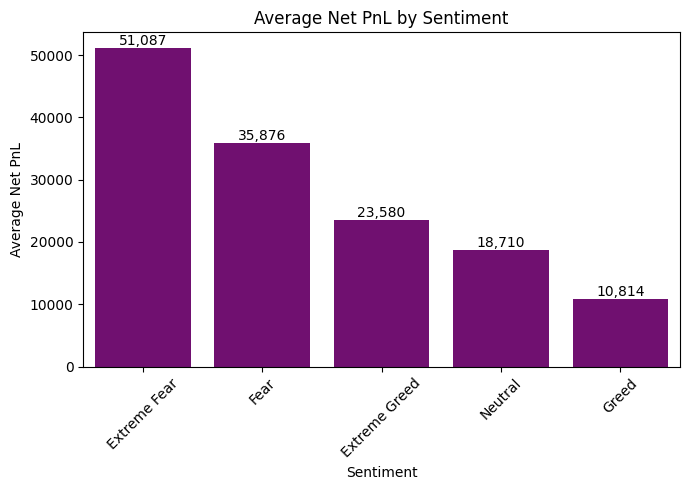

In [248]:
plt.figure(figsize=(7,5))

sorted_data = sentiment_analysis.sort_values('avg_net_pnl', ascending=False)

ax = sns.barplot(
    data=sorted_data,
    x='classification',
    y='avg_net_pnl',
    color = 'purple'
)
plt.title("Average Net PnL by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Net PnL")
plt.xticks(rotation=45)

for i, v in enumerate(sorted_data['avg_net_pnl']):
    ax.text(i, v, f"{v:,.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


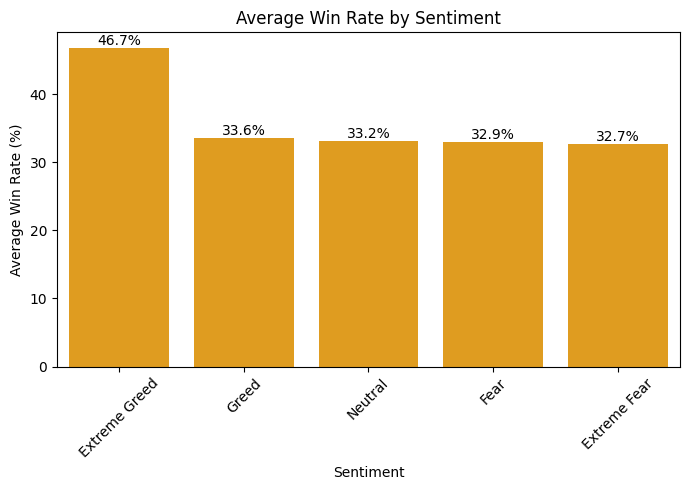

In [249]:
plt.figure(figsize=(7,5))

sorted_win = sentiment_analysis.sort_values('avg_win_rate', ascending=False)

ax = sns.barplot(
    data=sorted_win,
    x='classification',
    y='avg_win_rate',
    color='orange'
)

plt.title("Average Win Rate by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Win Rate (%)")
plt.xticks(rotation=45)

for i, v in enumerate(sorted_win['avg_win_rate']):
    ax.text(i, v, f"{v:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


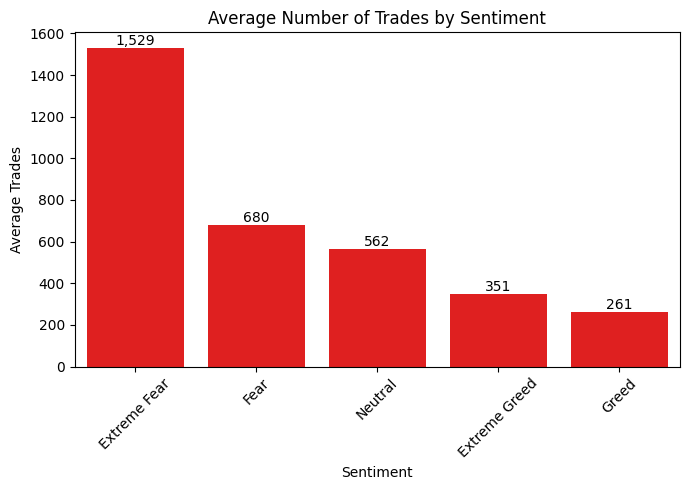

In [250]:
plt.figure(figsize=(7,5))

sorted_trades = sentiment_analysis.sort_values('avg_trades', ascending=False)

ax = sns.barplot(
    data=sorted_trades,
    x='classification',
    y='avg_trades',
    color='red'
)

plt.title("Average Number of Trades by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Trades")
plt.xticks(rotation=45)

for i, v in enumerate(sorted_trades['avg_trades']):
    ax.text(i, v, f"{v:,.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Step 6 — Bullish vs Bearish Behavior

Since the Direction column contains multiple action types,
we define:

Bullish actions:
- Buy
- Open Long

Bearish actions:
- Sell
- Open Short

We compute bullish vs bearish trade counts per sentiment.



In [251]:
trade_with_sentiment = trade.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

In [252]:
bullish = trade_with_sentiment[
    trade_with_sentiment['Direction'].isin(['Buy', 'Open Long'])
]

bearish = trade_with_sentiment[
    trade_with_sentiment['Direction'].isin(['Sell', 'Open Short'])
]

In [253]:
bull_counts = bullish.groupby('classification').size()
bear_counts = bearish.groupby('classification').size()

In [254]:
behavior_df = pd.DataFrame({
    'Bullish_trades': bull_counts,
    'Bearish_trades': bear_counts
}).fillna(0)

In [255]:
behavior_df['Bull_Bear_Ratio'] = (
    behavior_df['Bullish_trades'] /
    (behavior_df['Bearish_trades'] + 1)
)

In [256]:
behavior_df = behavior_df.reset_index()

behavior_df

,classification,Bullish_trades,Bearish_trades,Bull_Bear_Ratio
0,Extreme Fear,7812,4216,1.852502
1,Extreme Greed,11432,14827,0.770974
2,Fear,21031,14251,1.475653
3,Greed,13229,17650,0.749476
4,Neutral,13107,8699,1.506552


Traders exhibit contrarian behavior relative to market sentiment. During Fear periods, bullish trades significantly exceed bearish trades (Bull/Bear ratio ~1.85 in Extreme Fear), indicating aggressive dip-buying. Conversely, during Greed phases, bearish trades dominate (ratio < 0.8), suggesting profit-taking and short positioning at perceived market tops.

## Step 7 — Correlation Between Sentiment Index and Profitability

We analyze whether the Fear & Greed index value 
correlates with trader net profitability.

This helps determine whether profitability increases 
during high fear (low index values).


In [257]:
correlation = final_df[['value', 'net_pnl', 'win_rate', 'num_trades']].corr()

correlation

,value,net_pnl,win_rate,num_trades
value,1.000000,-0.078558,0.152485,-0.245241
net_pnl,-0.078558,1.000000,0.170206,0.350014
win_rate,0.152485,0.170206,1.000000,0.095852
num_trades,-0.245241,0.350014,0.095852,1.000000


## Step 8 — Actionable Strategy Recommendations

Based on the analysis, we propose the following strategy rules.


### Strategy Idea 1 — Increase Exposure During Fear

Since profitability is highest during Fear and Extreme Fear regimes,
traders may consider:

- Increasing trade frequency during Fear
- Allocating more capital during panic-driven volatility
- Using wider take-profit targets

---

### Strategy Idea 2 — Reduce Aggression During Greed

Greed regimes show:

- Lower average profitability
- Higher bearish positioning
- Lower activity

Suggested approach:
- Reduce leverage during Extreme Greed
- Focus on smaller, consistent trades
- Consider short bias strategies

---

### Strategy Idea 3 — Volatility-Based Position Sizing

Given the positive correlation between trade activity and net profitability:

- Increase position size during high volatility periods
- Reduce position size during low-volatility Greed phases


# Predicting next day profitibility

In [258]:
print(final_df.columns)

Index(['date', 'total_pnl', 'total_fees', 'num_trades', 'win_rate', 'net_pnl', 'classification', 'value'], dtype='object')


In [259]:
final_df = final_df.sort_values('date')

final_df['next_day_net_pnl'] = final_df['net_pnl'].shift(-1)
final_df['target'] = (final_df['next_day_net_pnl'] > 0).astype(int)

model_df = final_df.dropna(subset=['next_day_net_pnl'])


In [260]:
features = [
    'value',        # sentiment index
    'num_trades',   # activity
    'win_rate',     # performance
    'net_pnl'       # previous day pnl
]

X = model_df[features]
y = model_df['target']


In [261]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.8958333333333334

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.90      1.00      0.95        86

    accuracy                           0.90        96
   macro avg       0.45      0.50      0.47        96
weighted avg       0.80      0.90      0.85        96



C:\Users\Jaikishan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Jaikishan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Jaikishan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [262]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')


In [263]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.7708333333333334

Classification Report:

              precision    recall  f1-score   support

           0       0.07      0.10      0.08        10
           1       0.89      0.85      0.87        86

    accuracy                           0.77        96
   macro avg       0.48      0.47      0.48        96
weighted avg       0.80      0.77      0.79        96



# Clustering traders into behavioral archetypes

In [264]:
trader_df = trade.groupby('Account').agg(
    total_trades=('Trade ID', 'count'),
    avg_pnl=('Closed PnL', 'mean'),
    total_pnl=('Closed PnL', 'sum'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean()),
    avg_size_usd=('Size USD', 'mean'),
    avg_fee=('Fee', 'mean')
).reset_index()

trader_df.head()


,Account,total_trades,avg_pnl,total_pnl,win_rate,avg_size_usd,avg_fee
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,419.127768,1.600230e+06,0.359612,16159.576734,1.939579
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,6.577654,4.788532e+04,0.442720,1653.226327,0.374978
2,0x271b280974205ca63b716753467d5a371de622ab,3809,-18.492043,-7.043619e+04,0.301917,8893.000898,2.436593
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,9.951530,1.324648e+05,0.438585,507.626933,0.166657
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239,52.071011,1.686580e+05,0.519914,3138.894782,0.959616


In [265]:
from sklearn.preprocessing import StandardScaler

features = [
    'total_trades',
    'avg_pnl',
    'total_pnl',
    'win_rate',
    'avg_size_usd'
]

X = trader_df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [266]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
trader_df['cluster'] = kmeans.fit_predict(X_scaled)

trader_df.head()


,Account,total_trades,avg_pnl,total_pnl,win_rate,avg_size_usd,avg_fee,cluster
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,419.127768,1.600230e+06,0.359612,16159.576734,1.939579,2
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,6.577654,4.788532e+04,0.442720,1653.226327,0.374978,1
2,0x271b280974205ca63b716753467d5a371de622ab,3809,-18.492043,-7.043619e+04,0.301917,8893.000898,2.436593,1
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,9.951530,1.324648e+05,0.438585,507.626933,0.166657,1
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239,52.071011,1.686580e+05,0.519914,3138.894782,0.959616,1


In [267]:
cluster_summary = trader_df.groupby('cluster')[[
    'total_trades',
    'avg_pnl',
    'total_pnl',
    'win_rate',
    'avg_size_usd'
]].mean()

cluster_summary


,total_trades,avg_pnl,total_pnl,win_rate,avg_size_usd
cluster,,,,,
0,14326.142857,53.307498,5.721391e+05,0.484726,12962.781290
1,4016.956522,95.139108,1.107988e+05,0.382964,3544.209074
2,9275.500000,282.304758,1.871806e+06,0.348373,9998.731054


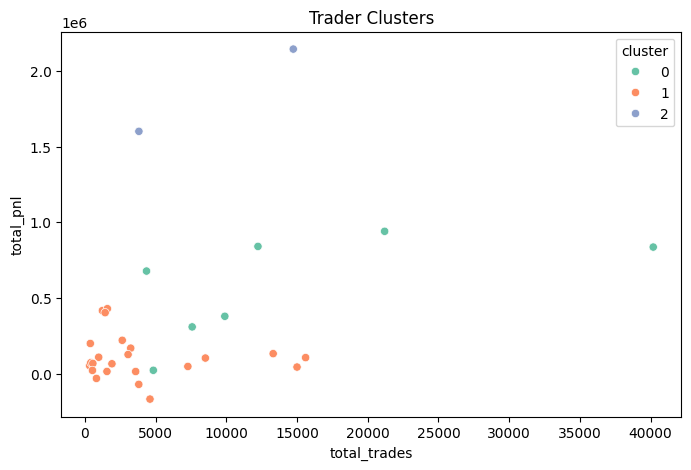

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=trader_df,
    x='total_trades',
    y='total_pnl',
    hue='cluster',
    palette='Set2'
)
plt.title("Trader Clusters")
plt.show()


In [271]:
final_df.to_csv("processed_daily_data.csv", index=False)
